In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
ls ~/data/2D_recovery_studies/increased_covmatrix

old/  xyz_seq/


In [3]:
input_file = (
    str(pathlib.Path.home())
    + '/data/2D_recovery_studies/increased_covmatrix/xyz_seq/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_with2D.root'
)

In [4]:
save_plots = False

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'b'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

In [5]:
if use_matter_antimatter == 'b':
    event_category_label = 'All reconstructed events'
elif use_matter_antimatter == 'm':
    event_category_label = 'Only matter events'
elif use_matter_antimatter == 'a':
    event_category_label = 'Only antimatter events'
else:
    raise ValueError

In [6]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'residuals_at_first_measurement_analysis/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v1.5)

In [7]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    with uproot3.open(filename) as file_root:
        tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_jagged:
            ## Ordinary branches
            df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            ## Jagged branches
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            ## Select first item for jagged branches
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            df = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Choose branches

In [8]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

### Original names

In [9]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

### New names

In [10]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")

branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [11]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

## Import ROOT file

In [12]:
df_events = root_file_to_df(input_file, branches, branches_jagged)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_events.rename(columns=column_rename_dictionary, inplace=True)

## Replace `ALGO_ID` with intelligible labels

In [13]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_events.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

# Apply further selections
## Select matter/antimatter

In [14]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [15]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3.142556e+03,17.418783,-2.138120e+02,7.316263e+04
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9.031324e+03,43.331825,3.264648e+01,3.185937e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-2.886078e+04,787.374390,-2.837228e+04,1.099216e+06
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,2.693933e+04,90.186363,5.198506e+03,6.694764e+05
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-1.309437e+04,201.608795,6.041502e+03,3.405917e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,1.101364,-0.737077,67.994382,-8364.634549,9946.496456,363.661658,-55.080362,5695.448012,1874.557415,1647.235689,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1.153532e+03,5.604915e+04
1286,1.101831,-0.738614,67.996588,-8958.541951,9208.223749,380.401838,-66.608245,5851.400767,1035.540220,1181.168672,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1.153532e+03,5.604915e+04
1287,1.102002,-0.738529,67.994842,4457.971071,4454.376071,417.663023,-71.699471,6060.194347,976.451341,1101.805233,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1.153532e+03,5.604915e+04
1288,0.759246,-0.783205,68.533907,7934.105388,11608.850331,-20.006221,-456.343834,6363.973976,3778.591130,2717.618862,...,0.852668,-9.328158,0.934082,-477.427002,54856.851562,-169540.968750,2.821246e+06,525616.687500,-8.721526e+06,1.451325e+08


# Helper functions

In [16]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_gen,
        color=mcolors.to_rgba(color_gen, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [17]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    counts_VF = sum(is_VF)
    counts_2D = sum(~is_VF)
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        #label="VF (" + str(counts_VF) + " evts)",
        label="Standard reconstructed",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         #label="2D-XYZ (" + str(counts_2D) + " evts)",
         label="Recovered",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    #plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [18]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Residuals at first measurement study

## Particle extrapolation safety check

To check if the extrapolator works "both ways" (i.e. if the Vertex Fitter does not change it too much), we perform some checks to verify that `*_PP_*` variables from the protoparticles are not (too) distinct from the `*_AtFirstMeas_*` variables extrapolated via Runge-Kutta at $z_\text{PP}$.

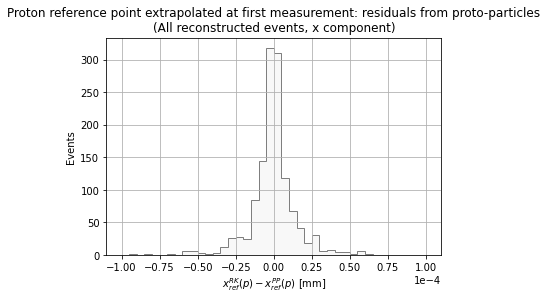

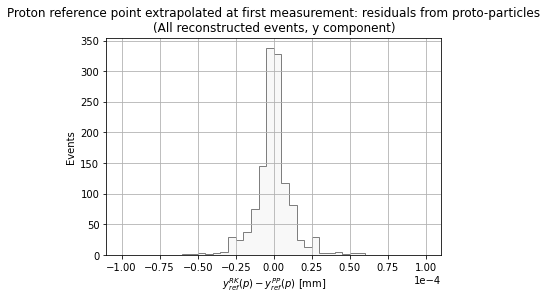

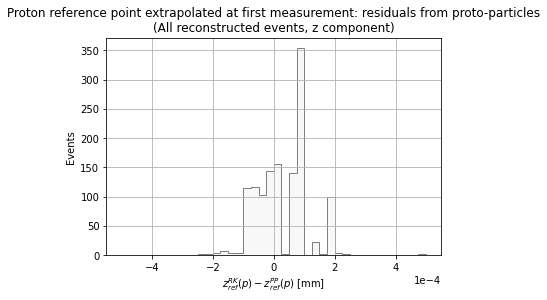

In [19]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-4,5e-4)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'p_AtFirstMeas_REFP_' + comp.upper()
    pp_feature = 'p_PP_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '_{ref}^{RK}(p) - ' + comp + '_{ref}^{PP}(p)$ [mm]',
        'plot_title': 'Proton reference point extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_AtFirstMeas_refpoint_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

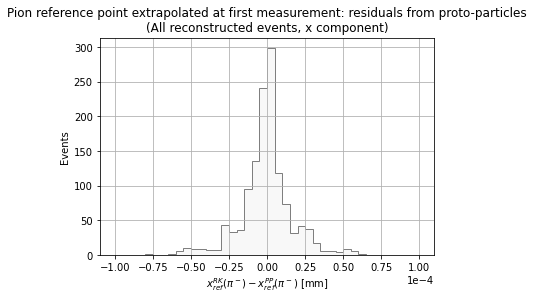

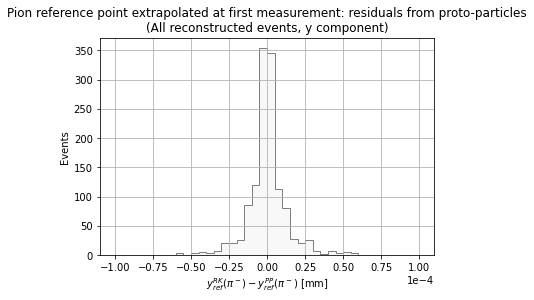

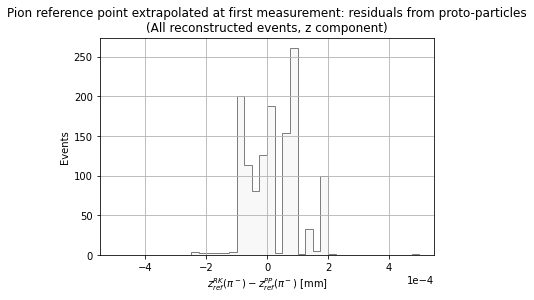

In [20]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-4,5e-4)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'pim_AtFirstMeas_REFP_' + comp.upper()
    pp_feature = 'pim_PP_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '_{ref}^{RK}(\pi^-) - ' + comp + '_{ref}^{PP}(\pi^-)$ [mm]',
        'plot_title': 'Pion reference point extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_AtFirstMeas_refpoint_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

Resolution is quite high on the reference point front. Now let's check the momenta, which are critical.

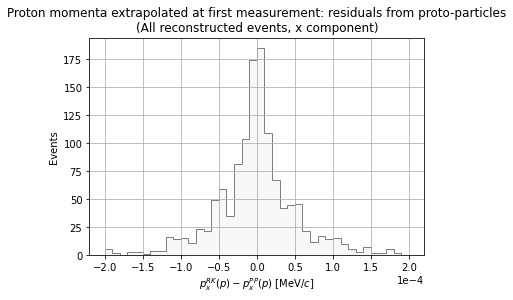

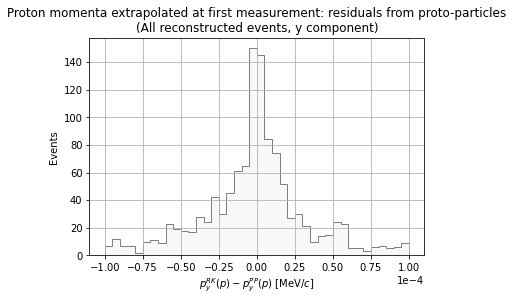

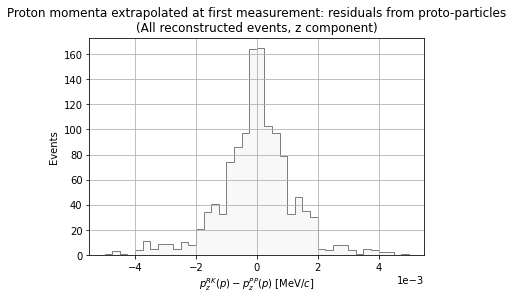

In [21]:
bias_boundary_dictionary = {
    'x': (-2e-4,2e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-3,5e-3)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'p_AtFirstMeas_P_' + comp.upper()
    pp_feature = 'p_PP_P' + comp.upper()

    plot_args = {
        'axis_label': '$p_' + comp + '^{RK}(p) - p_' + comp + '^{PP}(p)$ [MeV/$c$]',
        'plot_title': 'Proton momenta extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_AtFirstMeas_momentum_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

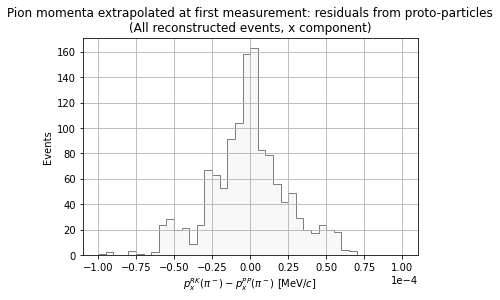

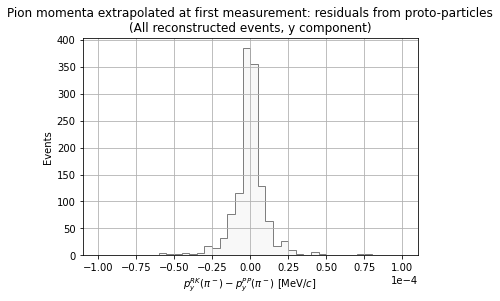

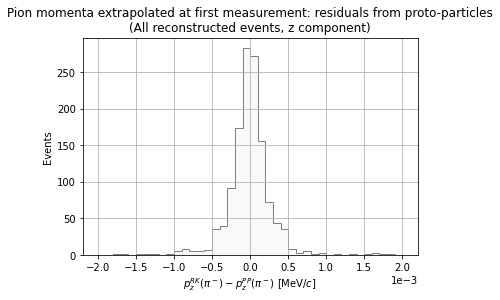

In [22]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-2e-3,2e-3)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'pim_AtFirstMeas_P_' + comp.upper()
    pp_feature = 'pim_PP_P' + comp.upper()

    plot_args = {
        'axis_label': '$p_' + comp + '^{RK}(\pi^-) - p_' + comp + '^{PP}(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Pion momenta extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_AtFirstMeas_momentum_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

Without going through the hassle of computing the relative residuals, a tolerance of some keV seems okay to me.
Extrapolating after fit back to the starting point yields basically the same results as the proto-particle saved before all this, therefore we can proceed with the juicy part.

## Proto-particle residuals (MC vs. reco) study

To do.